In [1]:

import numpy as np
import os
import subprocess
import time
import lzma
import pickle
import dimod
import re
import sys
import gzip
# from itertools import product, islice
# from dwave.system import DWaveSampler, FixedEmbeddingComposite
# from dwave.system.temperatures import h_to_fluxbias
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.interpolate import *
import ast

In [10]:
# Import libs and defining functions

import numpy as np
import os
import subprocess
import time
import lzma
import pickle
import dimod
import re
import sys
import gzip
from itertools import product, islice
# from dwave.system import DWaveSampler, FixedEmbeddingComposite
# from dwave.system.temperatures import h_to_fluxbias
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.interpolate import *
import ast

def xy_to_index(r, Lx, Ly):
    """Translates a squre grid coordinate (x, y) of a point to an index of the point."""
    x,y = r
    z = 0
    return Lx*y + x


def lattice_move(r, dr):
    """Takes an initial vector r of coordinates of K_{4,4} subgraphs on the Pegasus graph and a shift vector dr and outputs the coordinates of the shifted vector."""
    z0, y0 ,x0 = r
    dz, dy, dx = dr

    new_x = x0 + dx
    new_y = y0 + dy
    new_z = z0 + dz

    if new_z >= 2: # if the z depth over 2 the point shifts diagonally (x+1,y-1) to a different plane (z-depth) 
        shift = new_z // 3
        new_x = new_x + shift
        new_y = new_y - shift
        new_z =  new_z % 3

    if new_z < 0: # if the z depth less than 0 the point shifts diagonally to a different plane
        shift = new_z // 3
        new_x = new_x - shift
        new_y = new_y + shift
        new_z =  new_z % 3

    return (new_z, new_y, new_x)

def square_lattice(Lx,Ly):
    """Creates a square lattice grid with open boundary conditions of size L on the Pegasus graph.
      Outputs a dictionary of lattice indicies and the corresponding qubit indicies on the Pegaus graph.
      The origin of the lattice on the graph can be adjusted using the X0, Y0, Z0, coordiantes.
      
      The lattice is constructed by tiling smaller 4x4 squares. 
      """
    coords_dict = {}

    X0 = 0
    #Y0 = 14
    Y0 = 9
    Z0 = 1
    R0 = (Z0, Y0, X0)

    for y in range(Ly):
        for x in range(Lx):

            if y % 4 == 0: # 
                
                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                    
            if y % 4 == 1: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)

            if y % 4 == 2: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)

            if y % 4 == 3: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)+1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                    

    return coords_dict

def alt_square_lattice(Lx,Ly):
    """Creates an alternative square lattice grid with open boundary conditions of size L on the Pegasus graph by using
      unused qubits from the square_lattice embedding. These two lattices can be overlayed on top of each other to either 
      increase the yield, connect at the edges for different boundary conditions, or some other purpose (ancillas, ...).

      Outputs a dictionary of lattice indicies and the corresponding qubit indicies on the Pegaus graph.
      The origin of the lattice on the graph can be adjusted using the X0, Y0, Z0, coordiantes.
      
      The lattice is constructed by tiling smaller 4x4 squares. 
      """
    coords_dict = {}

    X0 = 0
    #Y0 = 14
    Y0 = 9
    Z0 = 1
    R0 = (Z0, Y0, X0)

    for y in range(Ly):
        for x in range(Lx):

            if y % 4 == 0: # 
                
                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 0)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 0)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 2)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 3)
                    
            if y % 4 == 1: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 3)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 0)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 0)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 2)

            if y % 4 == 2: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 2)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 3)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 0)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 0)

            if y % 4 == 3: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 0)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 2)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 3)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)+1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 0)
                    

    return coords_dict

def floodFill(image, x, y, newChar, oldChar=None):
    if oldChar == None:
        oldChar = image[y][x]
    if oldChar == newChar or image[y][x] != oldChar:
        return

    image[y][x] = newChar

    if image[(y+1)%HEIGHT][x] == oldChar:
        floodFill(image, x, (y+1)%HEIGHT, newChar, oldChar)
    if image[(y-1)%HEIGHT][x] == oldChar:
        floodFill(image, x, (y-1)%HEIGHT, newChar, oldChar)

    if image[y][(x+1)%WIDTH] == oldChar:
        floodFill(image, (x+1)%WIDTH, y, newChar, oldChar)
    if image[y][(x-1)%WIDTH] == oldChar:
        floodFill(image, (x-1)%WIDTH, y, newChar, oldChar)
    return

def printImage(image):
    plt.imshow(image)
    plt.axis('off')

def loops(image):
    domain_sizes = []
    domain_nr = 0
    oldChar = 0
    for y, i in enumerate(image):
        for x, j in enumerate(i):
            if j == oldChar:
                domain_nr += 1
                floodFill(image, x, y, domain_nr, oldChar=oldChar)
                domain_sizes.append(np.sum(image == domain_nr))
    return np.array(domain_sizes).astype(int)

def floodFill(image, x, y, newChar, oldChar=None):
    if oldChar is None:
        oldChar = image[y][x]
    if oldChar == newChar or image[y][x] != oldChar:
        return

    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if image[y][x] == oldChar:
            image[y][x] = newChar
            stack.append(((x + 1) % WIDTH, y))
            stack.append(((x - 1) % WIDTH, y))
            stack.append((x, (y + 1) % HEIGHT))
            stack.append((x, (y - 1) % HEIGHT))

In [17]:
print(sc(1,gc=gc))
print(sc(0.5,gc=gc))

0.311
0.344


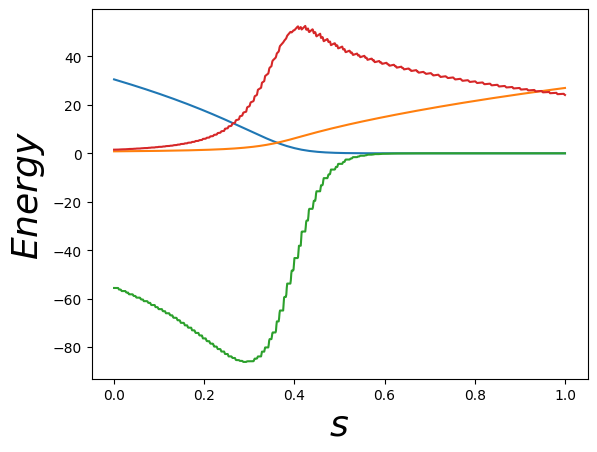

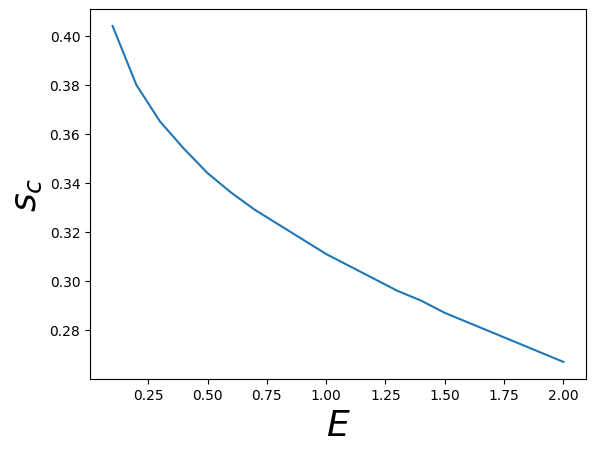

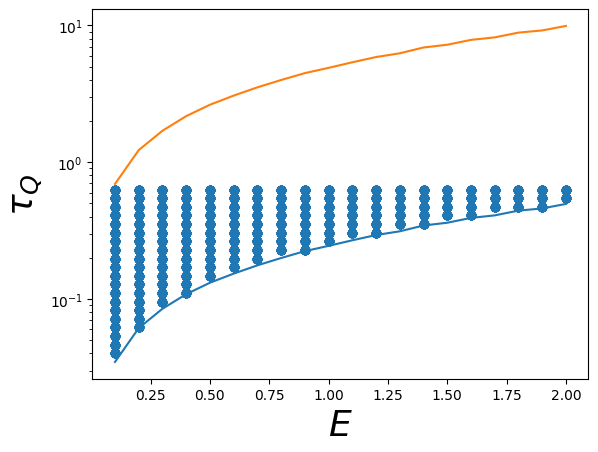

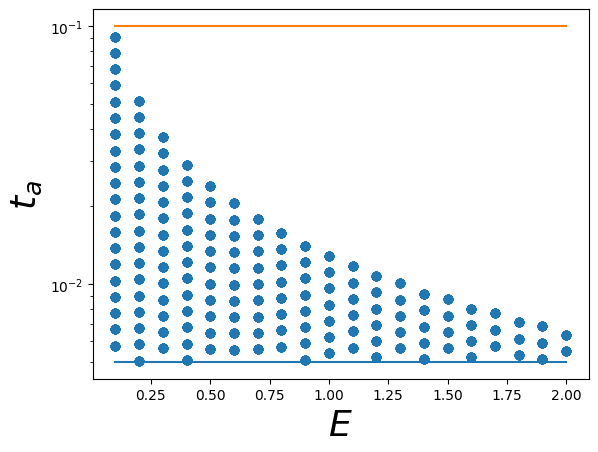

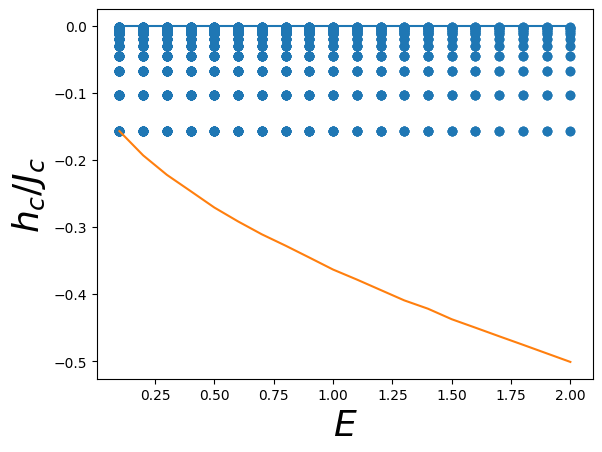

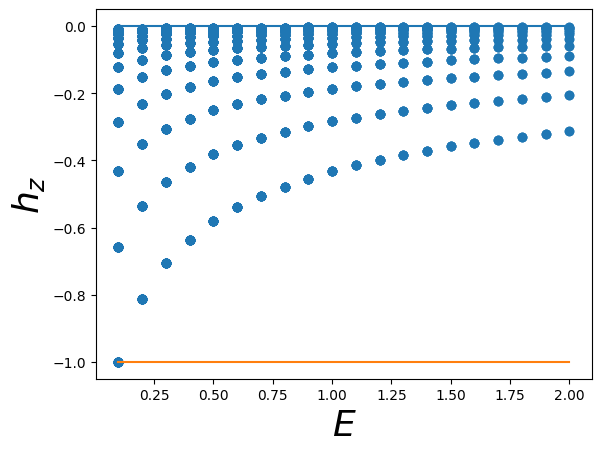

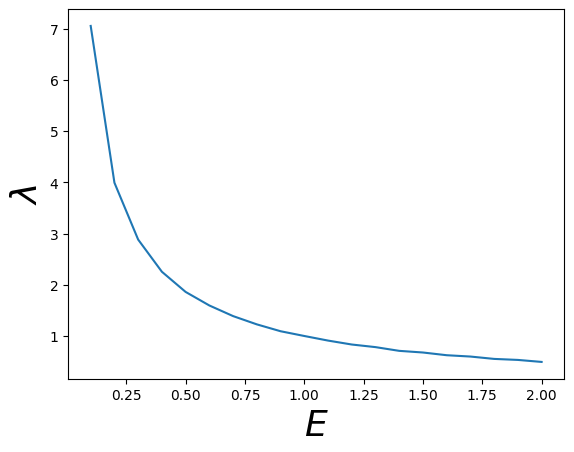

In [14]:
# df = pd.read_csv('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', sep=',', decimal='.')
# sa = np.array([round(df['s'][i],3) for i in range(1000)])
# Ga = np.array([round(df['A(s) (GHz)'][i],3)*np.pi for i in range(1000)])
# Ja = np.array([round(df['B(s) (GHz)'][i],3)*np.pi for i in range(1000)])


df = np.loadtxt('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', delimiter=",")
sa = df[:, 0]
Ga = df[:, 1] * np.pi # np.array([round(df['A(s) (GHz)'][i],3)*np.pi for i in range(1000)])
Ja = df[:, 2] * np.pi # np.array([round(df['B(s) (GHz)'][i],3)*np.pi for i in range(1000)])


gc = 3.04438

def sc(E,gc=1.):
    return sa[np.argmin(abs(Ga-gc*E*Ja))]
def Jc(E,gc=1.):
    return E * Ja[np.argmin(abs(Ga-gc*E*Ja))]
def Gc(E,gc=1.):
    return Ga[np.argmin(abs(Ga-gc*E*Ja))]
def Jcp(E,gc=1.):
    return np.gradient(E*Ja,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def Gcp(E,gc=1.):
    return np.gradient(Ga,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def tQ(ta,E,gc=1.):
    # ta must be in ns
    return ta / gc * Jc(E,gc) / (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def tQ_to_ta(tq,E,gc=1.):
    # ta must be in ns
    return tq * gc / Jc(E,gc) * (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def hcoJc(h,E,gc=1.):
    return E * h / Jc(E,gc)
def hcoJc_to_hz(hcoJc,E,gc=1.):
    return hcoJc / E * Jc(E,gc)
def en_to_lambda(E,gc=1.):
    return ((Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc)) / Jc(E,gc)) / ((Jcp(1.,gc)/Jc(1.,gc) - Gcp(1.,gc)/Gc(1.,gc)) / Jc(1.,gc))

en_range = np.linspace(.1,2.,20).round(6)

fig, ax = plt.subplots()
plt.xlabel('$s$', fontsize = 26)
plt.ylabel('$Energy$', fontsize = 26)
ax.plot(sa, Ga)
ax.plot(sa, Ja)
ax.plot(sa, np.gradient(Ga,sa))
ax.plot(sa, np.gradient(Ja,sa))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$s_c$', fontsize = 26)
ax.plot(en_range, [sc(e,gc=gc) for e in en_range])

ens, ens1, tqs, tas, hcojs, hzs = [], [], [], [], [], []
for en in en_range:
    for tq in np.geomspace(tQ(5,.1,gc=gc),tQ(100,2.,gc=gc),40):
        if tQ(5,en,gc=gc) < tq < tQ(100,en,gc=gc):
            for hz in np.geomspace(hcoJc(-1.,.1,gc=gc), hcoJc(-.01,.1,gc=gc), 12):
                if hcoJc(-1.,en,gc=gc) <= hz <= hcoJc(-.0,en,gc=gc):
                    if tq <= 0.633412:
                        hcojs.append(hz.round(6))
                        hzs.append(hcoJc_to_hz(hz,en,gc=gc).round(6))
                        ens.append(en.round(6))
                        tqs.append(tq.round(6))
                        tas.append((tQ_to_ta(tq,en,gc=gc)/1000.).round(6))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\tau_Q$', fontsize = 26)
ax.plot(en_range, [tQ(5,e,gc=gc) for e in en_range])
ax.plot(en_range, [tQ(100,e,gc=gc) for e in en_range])
ax.scatter(ens,tqs)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$t_a$', fontsize = 26)
ax.plot(en_range, [tQ_to_ta(tQ(5,e,gc=gc)/1000.,e,gc=gc) for e in en_range])
ax.plot(en_range, [tQ_to_ta(tQ(100,e,gc=gc)/1000.,e,gc=gc) for e in en_range])
ax.scatter(ens,tas)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_c/J_c$', fontsize = 26)
ax.plot(en_range, [hcoJc(-.0,e,gc=gc) for e in en_range])
ax.plot(en_range, [hcoJc(-1.,e,gc=gc) for e in en_range])
ax.scatter(ens,hcojs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_z$', fontsize = 26)
ax.plot(en_range, [-.0 for e in en_range])
ax.plot(en_range, [-1. for e in en_range])
ax.scatter(ens,hzs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\lambda$', fontsize = 26)
ax.plot(en_range, [en_to_lambda(e,gc=gc) for e in en_range])

In [8]:
nos = 2436
Lx = 42
Ly = 29 # Multiplied by 2, because the system on D-Wave are two 2D square lattice sheets, connected to form PBC.
J = -1.

hzenta_range = [[ens[i],tas[i],hzs[i]] for i in range(len(ens))] # The list of parameters I iterate over when submitting to D-Wave

profil = 'jvodebjuelich'
num_reads = 1000
embedding_string_short = 'sl54PBCish'
auto_scale = False
answer_mode="raw"
fast_anneal=True

#ds = range(0,L//2+1)
ds = range(0,1)

embedding_dir = 'C:/Users/jakav/Desktop/BACKUP/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Embedding/'

results_dir = 'C:/Users/jakav/Desktop/BACKUP/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Results/Results-6th-sweep/'

In [10]:
# These are the parameters I sent to D-Wave ordered as [E, t_a (in \mus), h_z (not equal to g_\parallel)].
# g_\parallel is h_z/J_c.
for i in hzenta_range:
    print(i)

[0.1, 0.005778, -1.0]
[0.1, 0.005778, -0.657933]
[0.1, 0.005778, -0.432876]
[0.1, 0.005778, -0.284804]
[0.1, 0.005778, -0.187382]
[0.1, 0.005778, -0.123285]
[0.1, 0.005778, -0.081113]
[0.1, 0.005778, -0.053367]
[0.1, 0.005778, -0.035112]
[0.1, 0.005778, -0.023101]
[0.1, 0.005778, -0.015199]
[0.1, 0.005778, -0.01]
[0.1, 0.006676, -1.0]
[0.1, 0.006676, -0.657933]
[0.1, 0.006676, -0.432876]
[0.1, 0.006676, -0.284804]
[0.1, 0.006676, -0.187382]
[0.1, 0.006676, -0.123285]
[0.1, 0.006676, -0.081113]
[0.1, 0.006676, -0.053367]
[0.1, 0.006676, -0.035112]
[0.1, 0.006676, -0.023101]
[0.1, 0.006676, -0.015199]
[0.1, 0.006676, -0.01]
[0.1, 0.007715, -1.0]
[0.1, 0.007715, -0.657933]
[0.1, 0.007715, -0.432876]
[0.1, 0.007715, -0.284804]
[0.1, 0.007715, -0.187382]
[0.1, 0.007715, -0.123285]
[0.1, 0.007715, -0.081113]
[0.1, 0.007715, -0.053367]
[0.1, 0.007715, -0.035112]
[0.1, 0.007715, -0.023101]
[0.1, 0.007715, -0.015199]
[0.1, 0.007715, -0.01]
[0.1, 0.008915, -1.0]
[0.1, 0.008915, -0.657933]
[0.1, 